# COMP90051 Project 2

In [2]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implement ε-Greedy and UCB

In [3]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}
        
        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [4]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """

    def __init__(self, narms, epsilon, Q0=np.inf):
        assert isinstance(narms, int), "'narms' should be an integer."
        assert narms > 0, "'narms' argument should be a positive integer."        
        assert isinstance(epsilon, float), "'epsilon' should be a float."
        assert epsilon >= 0 and epsilon <=1, "'epsilon' should be between 0 and 1 inclusive."        
        assert isinstance(Q0, float), "'Q0' should be a float."
        
        self.narms = narms                                              
        self.epsilon = epsilon    
        # MAB state to store expected pay off for each arm                                      
        self.exp_pay_off = np.full(narms, Q0)  
        # MAB state to store total rewards observed for each arm
        self.total_rewards = np.zeros(narms) 
        # MAB state to store total rounds for which each arm has been played        
        self.total_rounds = np.zeros(narms)    
              
    def play(self, tround, context=None):
        # Bernoulli random number generator with probabilty of success defined
        # by epsilon
        if np.random.binomial(n=1, p=self.epsilon) == 0:                
            # Exploit by playing the arm which has the highest expected pay-off  
            # so far with random tie-breaking         
            max_value = max(self.exp_pay_off)                       
            play_arm = [i for i, j in enumerate(self.exp_pay_off) if j == max_value] 
            play_arm = np.random.choice(play_arm) 
        else: 
            # Explore by randomly picking up an arm with equal probability                                                          
            play_arm = np.random.randint(low=0, high=self.narms)        
        
        return(play_arm + 1)    
        
    def update(self, arm, reward, context=None):
        # For currently played arm, update total rounds, total rewards, and
        # average rewards observed so far
        self.total_rounds[arm] += 1                 
        self.total_rewards[arm] += reward                  
        self.exp_pay_off[arm] = self.total_rewards[arm] / self.total_rounds[arm]    

In [5]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        assert isinstance(narms, int), "'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."        
        assert isinstance(rho, float), "'rho' should be a float."
        assert rho >= 0, "'rho' should be a non-negative float."        
        assert isinstance(Q0, float), "'Q0' should be a float."
        
        self.narms = narms                                              
        self.rho = rho 
        self.Q0 = Q0
        # MAB state to store average rewards observed for each arm             
        self.avg_rewards = np.zeros(narms) 
        # MAB state to store total rewards observed for each arm           
        self.total_rewards = np.zeros(narms) 
        # MAB state to store total rounds for which each arm has been played          
        self.total_rounds = np.zeros(narms)        
    
    def play(self, tround, context=None):     
        # Store expected pay off (UCB) for each arm
        UCB_exp_pay_off = np.full(self.narms, self.Q0) 
        # Update expected pay off (UCB) for each arm                                            
        for i in range(len(UCB_exp_pay_off)):
            # Only update the initialized expected pay off (UCB) values for an 
            # arm if it has been played at least once                                  
            if self.total_rounds[i] > 0:                    
                UCB_exp_pay_off[i] = (self.avg_rewards[i] + 
                                              np.sqrt((self.rho * np.log(tround)) / 
                                              self.total_rounds[i]))
        # Select arm which has the highest expected pay-off (UCB) so far with 
        # random tie-breaking         
        max_value = max(UCB_exp_pay_off)                       
        play_arm = [i for i, j in enumerate(UCB_exp_pay_off) if j == max_value] 
        play_arm = np.random.choice(play_arm) 
        
        return(play_arm + 1)         
        
    def update(self, arm, reward, context=None):
        # For currently played arm, update total rounds, total rewards, and
        # average rewards observed so far
        self.total_rounds[arm] += 1                        
        self.total_rewards[arm] += reward                  
        self.avg_rewards[arm] = self.total_rewards[arm] / self.total_rounds[arm]        

## 2. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """

    assert isinstance(nrounds, int), "'nrounds' argument should be an integer."
    assert nrounds > 0, "'nrounds' argument should be a positive integer."

    assert (not (np.isscalar(arms) or isinstance(arms, list))) and\
            all([isinstance(np.asscalar(element), int) for element in arms]),\
            "'arms' argument should be an array of integers."  
    assert (not (np.isscalar(rewards) or isinstance(rewards, list))) and\
            all([isinstance(element, float) for element in rewards]),\
            "'rewards' argument should be an array of float."         
    assert (not (np.isscalar(contexts) or isinstance(contexts, list))) and\
            all([[isinstance(element, float) for element in elements] for elements in contexts]),\
            "'contexts' argument should be an array of integer." 

    assert np.size(contexts, 0) == len(rewards) == len(arms), \
           "'contexts', 'rewards', and  'arms' arguments should have the same number of events."
    assert (np.size(contexts, 1) / mab.narms).is_integer() ,\
            "'contexts' argument should have same dimensions for each of the arms."  
            
    arm_history = []
    per_round_rewards = []
    tround = 1
    for i in range(len(arms)):
        # Play arm
        played_arm = mab.play(tround, contexts[i])                      
        # If played arm equals arm played by a uniformly-random policy
        if played_arm == arms[i]:       
            reward = rewards[i]
            # Update MAB state
            mab.update(played_arm-1, reward, contexts[i])    
            # Store arm and rewards history
            arm_history.append([played_arm, reward])
            # Store observed reward per round              
            per_round_rewards.append(reward)   
            # if the desired number of matching arms are found, stop and 
            # return per round rewards                         
            if tround == nrounds:                                       
                return(per_round_rewards)
            # Increment tround (only if arm playe by bandit equals arm in the 
            # dataset)
            tround += 1    
                                             
    return(per_round_rewards)

In [7]:
def readData(path):
    """
    Read evaluation dataset containing arms played, rewards observed, and 
    contexts presented to the arms
    
    Arguments
    =========
    path : folder path location of file to be read
        
    Returns
    =======
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
    """  
    try:
        open(path)
        dataset = np.loadtxt(path)
        # arms played by uniformly-random policy as recorded in dataset
        arms = dataset[:, 0].astype(int)  
        # rewards received by playing arms using a uniformly-random policy as 
        # recorded in dataset                                             
        rewards = dataset[:, 1]    
        # context vector                                         
        contexts = dataset[:, 2:]    
    except FileNotFoundError:     
        raise                            
    return(arms, rewards, contexts)

# Read dataset
arms, rewards, contexts = readData('C:/Users/ma_at/Google Drive/UniMelb - \
Masters Of Data Science - 2018-2019 - Assignment Solutions/Semester 2 2018/\
Statistical Machine Learning - COMP90051_2018SM2/Project 2/dataset.txt')  

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.1875


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.16875


## 3. Contextual Bandits

In [10]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        assert isinstance(narms, int), "'narms' should be an integer."
        assert narms > 0, "'narms' should be a positive integer."        
        assert isinstance(ndims, int), "'ndims' should be an integer."
        assert ndims > 0, "'ndims' should be a positive integer."     
        assert isinstance(alpha, float), "'alpha' should be a float."
        
        self.narms = narms                                              
        self.ndims = ndims                                              
        self.alpha = alpha      
        # Initialize to ndims dimensional identity matrix for each arm                                            
        self.A = [np.identity(ndims)] * narms   
        # Initialize to ndims dimensional zero vector for each arm
        self.b = [np.zeros(ndims)] * narms      
        
    def play(self, tround, context):
        # Initialize null coefficient vector for each arm
        theta_hat = [None] * self.narms                                         
        # Initialize expected pay off (LinUCB) for each arm
        p_a = np.zeros(self.narms)                    
        # Update expected pay-off for each arm
        for i in range(0, self.narms):                                      
            context_arm = context[(i * self.ndims) : ((i * self.ndims) + (self.ndims))]     
            inv_A = inv(self.A[i])
            theta_hat[i] = np.matmul(inv_A, self.b[i])   
            p_a[i] = (np.matmul(theta_hat[i], context_arm) + self.alpha *
                      np.sqrt(np.matmul(np.matmul(context_arm, inv_A), 
                      context_arm)))
        # Select arm which has the highest expected pay-off (UCB) so far with 
        # random tie-breaking 
        max_value = max(p_a)                     
        play_arm = [i for i, j in enumerate(p_a) if j == max_value] 
        play_arm = np.random.choice(play_arm)                           # 
            
        return(play_arm + 1)         
    
    def update(self, arm, reward, context):
        # Update vectors which will be used in calculation of expected pay_off 
        # (UCB) for the next round
        context_arm = context[(arm * self.ndims) : ((arm * self.ndims) + (self.ndims))]
        self.A[arm] = (np.add(self.A[arm], np.matmul(np.transpose(
                       np.matrix(context_arm)), np.matrix(context_arm))))            
        self.b[arm] = np.add(self.b[arm], (reward * context_arm))            

In [11]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 4. Evaluation
### 4.A.

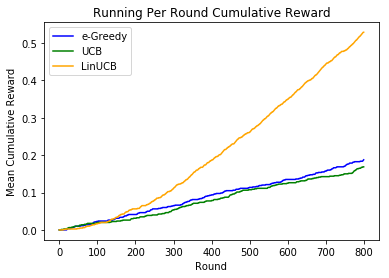

In [12]:
def plot(t):
    """
    Plot running per round cumulative reward for results on evaluation dataset
    for Epsilon-Greedy, Upper Confidence Bound (UCB), and contextual LinUCB 
    multi-armed bandits
    
    Arguments
    =========
    t : total number of rounds to be plotted
        
    Returns
    =======
    None
    """ 
    assert isinstance(t, int), "'t' argument should be an integer."
    assert t > 0, "'t' argument should be a positive integer."   
    # Initialize arrays with zeros to store mean cumulative rewards upto t 
    # rounds for each of the three implemented bandit algorithms
    EpsGreedy_rewards = np.zeros(t)
    UCB_rewards = np.zeros(t)
    LinUCB_rewards = np.zeros(t)
    # For each round, store the mean cumulative rewards upto that round
    for i in range(1,t):
        EpsGreedy_rewards[i] = np.sum(results_EpsGreedy[0:i]) / t
        UCB_rewards[i] = np.sum(results_UCB[0:i]) / t
        LinUCB_rewards[i] = np.sum(results_LinUCB[0:i]) / t
    # Plot running per round cumulative reward
    plt.plot(range(0,t), EpsGreedy_rewards, color='b', label='e-Greedy')
    plt.plot(range(0,t), UCB_rewards, color='g', label='UCB')
    plt.plot(range(0,t), LinUCB_rewards, color='orange', label='LinUCB')
    plt.xlabel('Round')
    plt.ylabel('Mean Cumulative Reward')
    plt.title('Running Per Round Cumulative Reward')
    plt.legend()
    plt.show()

# Plot running per round cumulative reward for three implemented 
# multi-armed bandits algorithms for 800 matching events    
plot(800)

### 4.B.

In [13]:
def gridSearch(list_of_alpha):
    """
    Grid search to find optimal value of hyper-parameter alpha
    
    Arguments
    =========
    list_of_alpha : arbitrary list of alpha values to be tried
        
    Returns
    =======
    Optimized alpha value and corresponding mean reward from LinUCB 
    """
    # Initialize best result to be 0
    best_result = 0.0
    mean_results_LinUCB = np.zeros(len(list_of_alpha))
    # Perform grid search over a list of alpha values
    for j in range(0, len(list_of_alpha)):
        mab = LinUCB(10, 10, list_of_alpha[j])
        mean_results_LinUCB[j] = np.mean(offlineEvaluate(mab, arms, rewards, 
                                                         contexts, 800))  
        if mean_results_LinUCB[j] > best_result:
            best_result = mean_results_LinUCB[j]
            best_alpha = list_of_alpha[j]

    print('Alpha', '\t Mean Rewards for 800 Matching Rounds')  
    for i in range(0, len(list_of_alpha)):
        print(list_of_alpha[i],'\t', mean_results_LinUCB[i])
            
    return(best_alpha, best_result)

# Run grid search to find optimal value of hyper-parameter alpha
list_of_alpha = np.array([-100.0,-10.0,-1.0,-0.5,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,1.0,2.0,5.0,10.0,100.0])
opt_alpha, opt_result = gridSearch(list_of_alpha)
            
print('\nBest Alpha is ', opt_alpha, ' with mean rewards of ', opt_result,\
      ' over 800 matching rounds')

Alpha 	 Mean Rewards for 800 Matching Rounds
-100.0 	 0.405
-10.0 	 0.43875
-1.0 	 0.4875
-0.5 	 0.47625
-0.1 	 0.4725
0.0 	 0.69
0.1 	 0.70875
0.2 	 0.6775
0.3 	 0.64375
0.4 	 0.635
0.5 	 0.6225
1.0 	 0.53
2.0 	 0.35375
5.0 	 0.18375
10.0 	 0.1225
100.0 	 0.0825

Best Alpha is  0.1  with mean rewards of  0.70875  over 800 matching rounds


## 5. KernelUCB

In [ ]:
# Do not edit. Special import for this section.
from sklearn.metrics.pairwise import rbf_kernel

In [ ]:
class KernelUCB(MAB):
    """
    Kernelised contextual multi-armed bandit (Kernelised LinUCB)
    
    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    gamma : float
        positive real explore-exploit parameter
    
    eta : float
        positive real explore-exploit parameter
    
    kern : callable
        a kernel function from sklearn.metrics.pairwise
    """
    def __init__(self, narms, ndims, gamma, eta, kern):
        
    
    def play(self, tround, context):
        
    
    def update(self, arm, reward, context):
        
    